In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install mplhep

In [ ]:
%%bash
cd /content/drive/MyDrive/UFRGS/TCC/Dados/repos/KADSB-Refinement
git pull

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/UFRGS/TCC/Dados/repos/KADSB-Refinement')

In [1]:
import os
from pathlib import Path

import numpy as np
import mplhep as hep
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset

from functions import EMA, load_data, sample_data
from plotting_functions import histogram, scatter, get_nhit, get_espec

mpl.style.use('classic')

CUDA = True
device = torch.device("cuda" if CUDA else "cpu")

In [2]:
abs_path = '/content/drive/MyDrive/UFRGS/TCC/Dados/'
data_dir_path = abs_path + 'datasets/SB_Refinement/'

In [3]:
from score_models import BottleneckScoreKAGN as ScoreNetworkEnergy
from score_models import BottleneckScoreKAGNAttentionConv as ScoreNetworkConv

## ----------------------------------------------------------------------------------------------------
## Energy
## ----------------------------------------------------------------------------------------------------
modelEnergy_type = "Bottleneck"
modelEnergy_iter = 19
i1 = 16
i2 = 8
energy_encoder_layers=[i1,i1]
pos_dim=i2
decoder_layers=[i1,i1]
modelEnergy_version = f"{energy_encoder_layers[0]}_{pos_dim}_{decoder_layers[0]}"
## ----------------------------------------------------------------------------------------------------
## Conv
## ----------------------------------------------------------------------------------------------------
modelConv_type = "BottleneckAttention"
modelConv_iter = 19
i3 = 16
conv_encoder_layers=[i3,i3]
temb_dim=4
conv_dof=1
modelConv_version = f"{conv_encoder_layers[0]}_{temb_dim}_{conv_dof}"
## ----------------------------------------------------------------------------------------------------
## Paths
## ----------------------------------------------------------------------------------------------------
models_dir_path = f'{abs_path}repos/sb_ref_kan/models/'
plots_dir_path = f'{abs_path}repos/sb_ref_kan/plots/'

models_energy_dir_path = f'{abs_path}repos/sb_ref_kan/models/Energy/{modelEnergy_type}/{modelEnergy_version}/'
models_conv_dir_path = f'{abs_path}repos/sb_ref_kan/models/Conv/{modelConv_type}/{modelConv_version}/'

full_modelEnergy_name = f"{modelEnergy_type}_{modelEnergy_version}"
full_modelConv_name = f"{modelConv_type}_{modelConv_version}"

plots_dir_path = f'{abs_path}repos/sb_ref_kan/plots/{full_modelEnergy_name}_{full_modelConv_name}/'


/home/marcelomdu/miniforge3/envs/sb_ref/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# class MLP(torch.nn.Module):
#     def __init__(self, input_dim, layer_widths, activate_final = False, activation_fn=F.relu):
#         super(MLP, self).__init__()
#         layers = []
#         prev_width = input_dim
#         for layer_width in layer_widths:
#             layers.append(torch.nn.Linear(prev_width, layer_width))
#             # # same init for everyone
#             # torch.nn.init.constant_(layers[-1].weight, 0)
#             prev_width = layer_width
#         self.input_dim = input_dim
#         self.layer_widths = layer_widths
#         self.layers = torch.nn.ModuleList(layers)
#         self.activate_final = activate_final
#         self.activation_fn = activation_fn
        
#     def forward(self, x):
#         for i, layer in enumerate(self.layers[:-1]):
#             x = self.activation_fn(layer(x))
#         x = self.layers[-1](x)
#         if self.activate_final:
#             x = self.activation_fn(x)
#         return x

# class ScoreNetworkEnergy(torch.nn.Module):
#     def __init__(self, encoder_layers=[256,256], pos_dim=128, decoder_layers=[256,256], x_dim=1, n_cond=1):

#         super().__init__()
#         self.temb_dim = pos_dim
#         t_enc_dim = pos_dim *2
#         self.locals = [encoder_layers, pos_dim, decoder_layers, x_dim]
#         self.n_cond = n_cond


#         self.net = MLP(3 * t_enc_dim + 1,
#                        layer_widths=decoder_layers +[x_dim],
#                        activate_final = False,
#                        activation_fn=torch.nn.LeakyReLU())

#         self.t_encoder = MLP(pos_dim,
#                              layer_widths=encoder_layers +[t_enc_dim],
#                              activate_final = False,
#                              activation_fn=torch.nn.LeakyReLU())

#         self.x_encoder = MLP(x_dim,
#                              layer_widths=encoder_layers +[t_enc_dim],
#                              activate_final = False,
#                              activation_fn=torch.nn.LeakyReLU())
            
#         self.e_encoder = MLP(1,
#                              layer_widths=encoder_layers +[t_enc_dim],
#                              activate_final = False,
#                              activation_fn=torch.nn.LeakyReLU())
        
        
#     def forward(self, x, t, cond=None, selfcond=None):
#         if len(x.shape) == 1:
#             x = x.unsqueeze(0)

#         if len(selfcond.shape) == 1:
#             selfcond = selfcond.unsqueeze(0)

#         temb = get_timestep_embedding(t, self.temb_dim)
#         temb = self.t_encoder(temb)
        
#         xemb = self.x_encoder(x)
        
            
#         if self.n_cond > 0:
#             eemb = cond
#             eemb = self.e_encoder(eemb)
#             h = torch.cat([xemb, temb, selfcond, eemb], -1)
#         else:
#             h = torch.cat([xemb ,temb, selfcond], -1)
                
#         out = self.net(h) 
#         return out
        
        
# class ScoreNetworkConv(torch.nn.Module):

#     def __init__(self, x_dim=100, n_cond=0):
#         super().__init__()
#         self.conv_dof = 32
#         self.n_cond = n_cond
        
#         self.temb_dim = 128
#         self.encoder_layers=[256,256]
#         self.t_enc_dim = self.conv_dof
        
#         self.bias = False
        
#         self.t_encoder = MLP(self.temb_dim,
#                              layer_widths=self.encoder_layers +[self.t_enc_dim],
#                              activate_final = False,
#                              activation_fn=torch.nn.LeakyReLU())

#         self.con_x_encoder1 = torch.nn.Conv2d(1, self.conv_dof, (3, 3), stride=(1, 1), 
#                                               padding=(1, 1),bias=self.bias)
#         self.con_x_encoder2 = torch.nn.Conv2d(self.conv_dof, self.conv_dof, (3, 3), stride=(1, 1), 
#                                               padding=(1, 1),bias=self.bias)
#         self.con_x_encoder3 = torch.nn.Conv2d(self.conv_dof, self.conv_dof, (3, 3), stride=(1, 1), 
#                                               padding=(1, 1),bias=self.bias)
#         self.con_x_encoder4 = torch.nn.Conv2d(self.conv_dof, self.conv_dof, (3, 3), stride=(1, 1), 
#                                               padding=(1, 1),bias=self.bias)
        
        
#         self.con_x_decoder1 = torch.nn.Conv2d(self.conv_dof*2+self.n_cond+1, self.conv_dof, (3, 3), stride=(1, 1), 
#                                               padding=(1, 1),bias=self.bias)
#         self.con_x_decoder2 = torch.nn.Conv2d(self.conv_dof, self.conv_dof, (3, 3), stride=(1, 1), 
#                                               padding=(1, 1),bias=self.bias)
#         self.con_x_decoder3 = torch.nn.Conv2d(self.conv_dof, self.conv_dof, (3, 3), stride=(1, 1), 
#                                               padding=(1, 1),bias=self.bias)
#         self.con_x_decoder4 = torch.nn.Conv2d(self.conv_dof, 1, (3, 3), stride=(1, 1), 
#                                               padding=(1, 1),bias=self.bias)
        
#         self.leakyReLU = torch.nn.LeakyReLU()

        
        
#     def forward(self, x, t, cond=None, selfcond=None):
#         if len(x.shape) == 1:
#             x = x.unsqueeze(0)

#         if self.n_cond > 0:
#             cond = cond.view(-1, self.n_cond, 1, 1).expand(-1, -1, 10, 10)

#         temb = get_timestep_embedding(t, self.temb_dim)
#         #print(t.size(), temb.size())
        
#         temb = self.t_encoder(temb).view(-1, self.t_enc_dim, 1, 1).expand(-1, -1, 10, 10)
        
#         xemb = self.leakyReLU(self.con_x_encoder1(x))
#         xemb = self.leakyReLU(self.con_x_encoder2(xemb))
#         xemb = self.leakyReLU(self.con_x_encoder3(xemb))
#         xemb = (self.con_x_encoder4(xemb))
        
#         if self.n_cond > 0:
#             h = torch.cat([xemb, temb, selfcond, cond], 1)
#         else:
#             h = torch.cat([xemb, temb, selfcond], 1)
            
#         out = self.leakyReLU(self.con_x_decoder1(h))
#         out = self.leakyReLU(self.con_x_decoder2(out))
#         out = self.leakyReLU(self.con_x_decoder3(out))
#         out = (self.con_x_decoder4(out))

#         return out

In [ ]:
line_style = {
    'Geant4':'dotted',
    'GFlash':'-',
    full_modelEnergy_name:'-',
    full_modelConv_name:'-',
}

colors = {
    'Geant4':'black',
    'GFlash':'red',
    full_modelEnergy_name:'#2ca25f',
    full_modelConv_name:'#7570b3',
}

rc('text', usetex=True)
rc('font', family='serif')
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

mpl.rcParams.update({'font.size': 19})
mpl.rcParams.update({'figure.titlesize': 11}) 
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 
mpl.rcParams.update({'lines.linewidth': 2})

hep.style.use("CMS") 

mpl.rcParams['text.usetex'] = False
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [5]:
# def imageplotting(data_l, data_name_l):
    
#     fig = plt.figure(figsize=(6*len(data_l),6))
#     fig.set_facecolor('white')
#     outer = gridspec.GridSpec(1, len(data_l) , wspace=0.2, hspace=0.0)

#     for (i, (d, d_n)) in enumerate( zip(data_l, data_name_l) ):

#         subplot = fig.add_subplot(outer[i])

#         im = subplot.imshow(np.mean(d, 0), norm=LogNorm(vmin=0.001, vmax=20), filternorm=False, interpolation='none', cmap = 'viridis',  origin='lower')
#         subplot.patch.set_facecolor('white')
#         subplot.title.set_text(d_n)
#         subplot.set_xlabel('y [cells]')
#         subplot.set_ylabel('x [cells]')
#         fig.colorbar(im)

# def FormatFig(xlabel,ylabel,ax0):
#     #Limit number of digits in ticks
#     # y_loc, _ = plt.yticks()
#     # y_update = ['%.1f' % y for y in y_loc]
#     # plt.yticks(y_loc, y_update) 
#     ax0.set_xlabel(xlabel,fontsize=20)
#     ax0.set_ylabel(ylabel)
        

#     # xposition = 0.9
#     # yposition=1.03
#     # text = 'H1'
#     # WriteText(xposition,yposition,text,ax0)

    
# def SetGrid(ratio=True):
#     if ratio:
#         fig = plt.figure(figsize=(9, 9))
#         gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
#         gs.update(wspace=0.025, hspace=0.1)
#     else:
#         fig = plt.figure(figsize=(9, 7))
#         gs = gridspec.GridSpec(1, 1)
#     return fig,gs


# def GetEMD(ref,array,weights_arr,nboot = 100):
#     from scipy.stats import wasserstein_distance
#     ds = []
#     for _ in range(nboot):
#         #ref_boot = np.random.choice(ref,ref.shape[0])
#         arr_idx = np.random.choice(range(array.shape[0]),array.shape[0])
#         array_boot = array[arr_idx]
#         w_boot = weights_arr[arr_idx]
#         ds.append(wasserstein_distance(ref,array_boot,v_weights=w_boot))
    
#     return np.mean(ds), np.std(ds)
#     # mse = np.square(ref-array)/ref
#     # return np.sum(mse)


# def get_triangle_distance(x,y,binning):
#     dist = 0
#     w = binning[1:] - binning[:-1]
#     for ib in range(len(x)):
#         dist+=0.5*w[ib]*(x[ib] - y[ib])**2/(x[ib] + y[ib]) if x[ib] + y[ib] >0 else 0.0
#     return dist*1e3

        
# def HistRoutine(feed_dict,xlabel='',ylabel='',reference_name='Truth',logy=False,binning=None,label_loc='best',plot_ratio=False,weights=None,uncertainty=None,triangle=True, y_lim_ratio=[0.5,1.5], title='', density=True, y_range=None):
#     assert reference_name in feed_dict.keys(), "ERROR: Don't know the reference distribution"

#     ref_plot = {'histtype':'stepfilled','alpha':0.2}
#     other_plots = {'histtype':'step','linewidth':2}
#     fig,gs = SetGrid(ratio=plot_ratio) 
#     ax0 = plt.subplot(gs[0])

#     if plot_ratio:
#         plt.xticks(fontsize=0)
#         ax1 = plt.subplot(gs[1],sharex=ax0)

    
#     if binning is None:
#         binning = np.linspace(np.quantile(feed_dict[reference_name],0.0),np.quantile(feed_dict[reference_name],1),30)
        
#     xaxis = [(binning[i] + binning[i+1])/2.0 for i in range(len(binning)-1)]
#     reference_hist,_ = np.histogram(feed_dict[reference_name],bins=binning,density=density,weights=weights[reference_name])

#     d_list = []
#     err_list = []
    
#     maxy = 0    
#     for ip,plot in enumerate(feed_dict.keys()):
#         plot_style = ref_plot if reference_name == plot else other_plots
#         if weights is not None:
#             dist,_,_=ax0.hist(feed_dict[plot],bins=binning,label=plot,linestyle=line_style[plot],color=colors[plot],density=density,weights=weights[plot],**plot_style)
#         else:
#             dist,_,_=ax0.hist(feed_dict[plot],bins=binning,label=plot,linestyle=line_style[plot],color=colors[plot],density=density,**plot_style)

            
#         if triangle:
#             print(plot)
#             d,err = GetEMD(feed_dict[reference_name][:100000],feed_dict[plot][:100000],weights[plot][:100000])
#             print("EMD distance is: {}+-{}".format(d,err))
#             #d = get_triangle_distance(dist,reference_hist,binning)
#             #print("Triangular distance is: {0:.2g}".format(d))
#             if not reference_name == plot:
#                 #label_list.append(plot + ' EMD: {0:.2g} $\pm$ {1:.2g}'.format(d, err))
#                 #label_list.append(plot)
#                 d_list.append(d)
#                 #label_list.append(' $\pm$ ')
#                 err_list.append(err)
                
#             if reference_name == plot:
#                 #label_list.append(plot + ' EMD: {0:.2g} $\pm$ {1:.2g}'.format(d, err))
#                 #label_list.append(plot)
#                 d_list.append(d)
#                 #label_list.append(' $\pm$ ')
#                 err_list.append(err)
#                 #label_list.append(plot)

            
#         if np.max(dist) > maxy:
#             maxy = np.max(dist)
            
#         if plot_ratio:
#             if reference_name!=plot:
#                 ratio = np.ma.divide(dist,reference_hist).filled(0)                
#                 ax1.plot(xaxis,ratio,color=colors[plot],marker='+',ms=8,lw=0,markerfacecolor='none',markeredgewidth=3)
#                 if uncertainty is not None:
#                     for ibin in range(len(binning)-1):
#                         xup = binning[ibin+1]
#                         xlow = binning[ibin]
#                         ax1.fill_between(np.array([xlow,xup]),
#                                          uncertainty[ibin],-uncertainty[ibin], alpha=0.3,color='k')    
 
#     len_list = []
    
#     for err in (err_list):
#         #print('{0:.2g}'.format(err))
#         #print(len('{0:.2g}'.format(err)))
#         temp = '{0:.2g}'.format(err)
#         if 'e' in temp:
#             len_list.append(int(temp[-1])+2)
#         else:
#             len_list.append(len(temp))
     
#     precision = max(len_list)-2

        
#     label_list = []
    
#     for ip,plot in enumerate(feed_dict.keys()):
#         label_list.append(plot)

#     for d in (d_list):
#         label_list.append('EMD: {0:.{1}f}'.format(d, precision))
#         ax0.plot(binning[5], -100000, alpha=0.0)

#     for ip,plot in enumerate(feed_dict.keys()):
#         label_list.append(' $\pm$ ')
#         ax0.plot(binning[5], -100000, alpha=0.0)

#     for err in (err_list):
#         label_list.append('{0:.{1}f}'.format(err, precision))
#         ax0.plot(binning[5], -100000, alpha=0.0)

#     out = ' ' 
#     for ip,plot in enumerate(feed_dict.keys()):
#         out = out + (' & {0:.{1}f}'.format(d_list[ip], precision)) + '$\pm$' + ('{0:.{1}f}'.format(err_list[ip], precision))
    
#     print('{}, {} , {}: '.format(xlabel, title, plot) + out)
    
#     out = ' ' 
#     for ip,plot in enumerate(feed_dict.keys()):
#         temp = '{0:.1g}'.format(err_list[ip])
#         if 'e' in temp:
#             precision = temp[-1]
#         else:
#             precision = (len(temp))-2
#         out = out + (' & {0:.{1}f}'.format(d_list[ip], precision)) + '(' + ('{0:.{1}f})'.format(err_list[ip], precision))[-2:]
    
#     print('{}, {} , {}: '.format(xlabel, title, plot) + out)
    

#     if logy:
#         ax0.set_yscale('log')

#     if triangle:
#         ax0.legend(loc=label_loc,fontsize=16,ncol=4, labels=label_list, columnspacing=-1.15)
#     else:
#         ax0.legend(loc=label_loc,fontsize=16,ncol=1)

#     ax0.title.set_text(title)
#     ax0.title.set_size(25)
    
#     if y_range is None:
#         ax0.set_ylim(0,1.3*maxy)
#     else:
#         ax0.set_ylim(y_range[0], y_range[1])
    
#     if plot_ratio:
#         FormatFig(xlabel = "", ylabel = ylabel,ax0=ax0) 
#         plt.ylabel('Ratio to Truth')
#         plt.axhline(y=1.0, color='r', linestyle='-',linewidth=1)
#         # plt.axhline(y=10, color='r', linestyle='--',linewidth=1)
#         # plt.axhline(y=-10, color='r', linestyle='--',linewidth=1)
#         plt.ylim(y_lim_ratio)
#         plt.xlabel(xlabel)
#     else:
#         FormatFig(xlabel = xlabel, ylabel = ylabel,ax0=ax0) 
       
#     try:
#         ax0.ticklabel_format(useOffset=False)
#     except:
#         pass
#     return fig,ax0


# def ScatterRoutine(xdata, ydata, data_label ,xlabel='',ylabel='',label_loc='best', title=''):

#     fig,gs = SetGrid(ratio=False) 
#     ax0 = plt.subplot(gs[0])

#     ax0.scatter(xdata, ydata, label=data_label)

#     ax0.legend(loc=label_loc,fontsize=16,ncol=2)
#     ax0.title.set_text(title)
#     ax0.title.set_size(25)
#     FormatFig(xlabel = xlabel, ylabel = ylabel,ax0=ax0) 
       
#     ax0.ticklabel_format(useOffset=False)
#     return fig,ax0


In [ ]:
file_path_gflash = data_dir_path + 'run_GFlash01_100k_10_100GeV_eval_full.npy'
file_path_g4 = data_dir_path + 'run_Geant_100k_10_100GeV_eval_full.npy'

data = load_data(file_path_gflash=file_path_gflash, file_path_g4=file_path_g4, normalize_energy=True)

In [6]:
# file_path_gflash = data_dir_path + 'run_GFlash01_100k_10_100GeV_eval_full.npy'
# file_path_g4 = data_dir_path + 'run_Geant_100k_10_100GeV_eval_full.npy'
# file_name = '.npy'

# energy_voxel_g4 = np.load(file_path_g4 + file_name)[:, 0:100].astype(np.float32)
# energy_voxel_gflash  = np.load(file_path_gflash + file_name)[:, 0:100].astype(np.float32)

# energy_particle_g4 = np.load(file_path_g4 + file_name)[:, 200:201].astype(np.float32)/10000.0
# energy_particle_gflash  = np.load(file_path_gflash + file_name)[:, 200:201].astype(np.float32)/10000.0


# # sort by incident energy to define pairs
# mask_energy_particle_g4 = np.argsort(energy_particle_g4, axis=0)[:,0]
# mask_energy_particle_gflash = np.argsort(energy_particle_gflash, axis=0)[:,0]

# energy_particle_g4 = energy_particle_g4[mask_energy_particle_g4]
# energy_particle_gflash = energy_particle_gflash[mask_energy_particle_gflash]

# energy_voxel_g4 = energy_voxel_g4[mask_energy_particle_g4]
# energy_voxel_gflash = energy_voxel_gflash[mask_energy_particle_gflash]

# # reshuffle consistently
# mask_shuffle = np.random.permutation(energy_particle_g4.shape[0])

# energy_particle_g4 = energy_particle_g4[mask_shuffle]
# energy_particle_gflash = energy_particle_gflash[mask_shuffle]

# energy_voxel_g4 = energy_voxel_g4[mask_shuffle]
# energy_voxel_gflash = energy_voxel_gflash[mask_shuffle]



# energy_g4 = np.sum(energy_voxel_g4, 1, keepdims=True)
# energy_gflash = np.sum(energy_voxel_gflash, 1, keepdims=True)


# energy_voxel_g4 = np.reshape(energy_voxel_g4, (-1, 1, 10, 10))
# energy_voxel_gflash = np.reshape(energy_voxel_gflash, (-1, 1, 10, 10))


# energy_voxel_g4 = energy_voxel_g4/np.tile(np.reshape(energy_g4, (-1, 1, 1, 1)), (1, 1, 10, 10))
# energy_voxel_gflash = energy_voxel_gflash/np.tile(np.reshape(energy_gflash, (-1, 1, 1, 1)), (1, 1, 10, 10))


# shifter_energy_fullrange_g4 = np.mean(energy_g4, 0)
# shifter_energy_fullrange_gflash = np.mean(energy_gflash, 0)
# scaler_energy_fullrange_g4 = np.std(energy_g4)
# scaler_energy_fullrange_gflash = np.std(energy_gflash, 0)



# energy_g4 = energy_g4/energy_particle_g4
# energy_gflash = energy_gflash/energy_particle_gflash


# shifter_g4 = np.mean(energy_voxel_g4, 0)
# shifter_gflash = np.mean(energy_voxel_gflash, 0)
# scaler_g4 = np.std(energy_voxel_g4, 0)
# scaler_gflash = np.std(energy_voxel_gflash, 0)

# energy_voxel_g4 = (energy_voxel_g4 - shifter_g4)/scaler_g4
# energy_voxel_gflash = (energy_voxel_gflash - shifter_gflash)/scaler_gflash



# shifter_energy_g4 = np.mean(energy_g4, 0)
# shifter_energy_gflash = np.mean(energy_gflash, 0)
# scaler_energy_g4 = np.std(energy_g4)
# scaler_energy_gflash = np.std(energy_gflash, 0)

# energy_g4 = (energy_g4 - shifter_energy_g4)/scaler_energy_g4
# energy_gflash = (energy_gflash - shifter_energy_gflash)/scaler_energy_gflash




torch.Size([100000, 1, 10, 10])
torch.Size([100000, 1, 10, 10])
torch.Size([1, 10, 10])
torch.Size([1, 10, 10])
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010], device='cuda:0', dtype=torch.float64)
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010], device='cuda:0', dtype=torch.float64)


In [ ]:
energy_voxel_g4 = data['energy_voxel_g4']
energy_voxel_gflash = data['energy_voxel_gflash']
energy_gflash = data['energy_gflash']
energy_g4 = data['energy_g4']
energy_particle_gflash = data['energy_particle_gflash']
energy_particle_g4 = data['energy_particle_g4']

batch_size = 10000

npar = int(energy_voxel_g4.shape[0])
            
X_init = energy_voxel_gflash
Y_init = np.concatenate((energy_gflash, energy_g4, energy_particle_gflash), 1)
init_sample = torch.tensor(X_init).view(X_init.shape[0], 1, 10, 10)
init_lable = torch.tensor(Y_init)
scaling_factor = 7
#init_sample = (init_sample - init_sample.mean()) / init_sample.std() * scaling_factor
init_ds = TensorDataset(init_sample, init_lable)
init_dl = DataLoader(init_ds, batch_size=batch_size, shuffle=False)
#init_dl = repeater(init_dl)
print(init_sample.shape)

X_final = energy_voxel_g4
Y_final = np.concatenate((energy_g4, energy_gflash, energy_particle_g4), 1)
scaling_factor = 7.
final_sample = torch.tensor(X_final).view(X_final.shape[0], 1, 10, 10)
final_label = torch.tensor(Y_final)
#final_sample = (final_sample - final_sample.mean()) / final_sample.std() * scaling_factor
final_ds = TensorDataset(final_sample, final_label)
final_dl = DataLoader(final_ds, batch_size=batch_size, shuffle=False)
#final_dl = repeater(final_dl)

#mean_final = torch.tensor(0.)
#var_final = torch.tensor(1.*10**3) #infty like

mean_final = torch.zeros(1, 10, 10).to(device)
var_final = 1.*torch.ones(1, 10, 10).to(device)

print(final_sample.shape)
print(mean_final.shape)
print(var_final.shape)

dls = {'f': init_dl, 'b': final_dl}

d = init_sample[0].shape  # shape of object to diffuse
dy = init_lable[0].shape  # shape of object to diffuse
de = [1]  # shape of object to diffuse

lr = 1e-5

num_steps_voxel = 20
gamma_max_voxel = 0.001
gamma_min_voxel = 0.001

n = num_steps_voxel//2
gamma_half_voxel = np.linspace(gamma_min_voxel, gamma_max_voxel, n)
gammas_voxel = np.concatenate([gamma_half_voxel, np.flip(gamma_half_voxel)])
gammas_voxel = torch.tensor(gammas_voxel).to(device)
T_voxel = torch.sum(gammas_voxel)

print(gammas_voxel)

num_steps_energy = 20
gamma_max_energy = 0.001
gamma_min_energy = 0.001

n = num_steps_energy//2
gamma_half_energy = np.linspace(gamma_min_energy, gamma_max_energy, n)
gammas_energy = np.concatenate([gamma_half_energy, np.flip(gamma_half_energy)])
gammas_energy = torch.tensor(gammas_energy).to(device)
T_energy = torch.sum(gammas_energy)

print(gammas_energy)

In [7]:
## ----------------------------------------------------------------------------------------------------
## Energy
## ----------------------------------------------------------------------------------------------------
modelEnergy_f = ScoreNetworkEnergy(encoder_layers=energy_encoder_layers,
                                   pos_dim=pos_dim,
                                   decoder_layers=decoder_layers,
                                   n_cond = 1).to(device)

modelEnergy_b = ScoreNetworkEnergy(encoder_layers=energy_encoder_layers,
                                   pos_dim=pos_dim,
                                   decoder_layers=decoder_layers,
                                   n_cond = 1).to(device)

modelEnergy_name = str(modelEnergy_f.__class__)[21:-2]



## ----------------------------------------------------------------------------------------------------
## Conv
## ----------------------------------------------------------------------------------------------------
modelConv_f = ScoreNetworkConv(encoder_layers=conv_encoder_layers,
                               temb_dim=temb_dim,
                               conv_dof=conv_dof,
                               n_cond = init_lable.size(1)).to(device)

modelConv_b = ScoreNetworkConv(encoder_layers=conv_encoder_layers,
                               temb_dim=temb_dim,
                               conv_dof=conv_dof,
                               n_cond = init_lable.size(1)).to(device)

modelConv_name = str(modelConv_f.__class__)[21:-2]


In [8]:

## decay=1.0: No change on update
## decay=0.0: No memory of previous updates, memory is euqal to last update
## decay=0.9: New value 9 parts previous updates, 1 part current update
## decay=0.95: New value 49 parts previous updates, 1 part current update

#------------------------------------------------------------------------------------------

# modelEnergy_f = ScoreNetworkEnergy(n_cond = 1).to(device)
# modelEnergy_b = ScoreNetworkEnergy(n_cond = 1).to(device)

#------------------------------------------------------------------------------------------

modelEnergy_f = torch.nn.DataParallel(modelEnergy_f)
modelEnergy_b = torch.nn.DataParallel(modelEnergy_b)

netEnergy_f = EMA(model=modelEnergy_f, decay=0.95).to(device)
netEnergy_b = EMA(model=modelEnergy_b, decay=0.95).to(device)

netsEnergy  = {'f': netEnergy_f, 'b': netEnergy_b }


netsEnergy['f'].load_state_dict(torch.load(f"{models_energy_dir_path}Iter{modelEnergy_iter}_net_f_GFlash_Energy{modelEnergy_name}_{modelEnergy_version}_.pth", map_location=device))
netsEnergy['b'].load_state_dict(torch.load(f"{models_energy_dir_path}Iter{modelEnergy_iter}_net_b_GFlash_Energy{modelEnergy_name}_{modelEnergy_version}_.pth", map_location=device))


netsEnergy['f'].eval()
netsEnergy['b'].eval()

#------------------------------------------------------------------------------------------

# modelConv_f = ScoreNetworkConv(n_cond = init_lable.size(1)).to(device)
# modelConv_b = ScoreNetworkConv(n_cond = init_lable.size(1)).to(device)

#------------------------------------------------------------------------------------------

modelConv_f = torch.nn.DataParallel(modelConv_f)
modelConv_b = torch.nn.DataParallel(modelConv_b)


netConv_f = EMA(model=modelConv_f, decay=0.95).to(device)
netConv_b = EMA(model=modelConv_b, decay=0.95).to(device)

netsConv  = {'f': netConv_f, 'b': netConv_b }

netsConv['f'].load_state_dict(torch.load(f"{models_conv_dir_path}Iter{modelConv_iter}_net_f_GFlash_Conv{modelConv_name}_{modelConv_version}_.pth", map_location=device))
netsConv['b'].load_state_dict(torch.load(f"{models_conv_dir_path}Iter{modelConv_iter}_net_b_GFlash_Conv{modelConv_name}_{modelConv_version}_.pth", map_location=device))

netsConv['f'].eval()
netsConv['b'].eval()

Path(plots_dir_path).mkdir(parents=True, exist_ok=True)

In [9]:
# def sample (forward_or_backward = 'f', forward_or_backward_rev = 'b'):
#     data_orig = []
#     data_energy_particle = []
#     data_x = []
#     data_y = []
#     iteration = -1

#     for b, dat in enumerate(dls[forward_or_backward]):    
#         x, y = dat
#         x = x.float().to(device)
#         y = y.float().to(device)
        
        
#         x_orig = x.clone()

#         N = x.shape[0]
        
#         #gammas_new = gammas.reshape((1, num_steps, 1)).repeat((N, 1, 1))
        
        
#         steps_voxel = torch.arange(num_steps_voxel).to(device)
#         time_voxel = torch.cumsum(gammas_voxel, 0).to(device).float()
#         steps_voxel = steps_voxel.reshape((1, num_steps_voxel, 1)).repeat((N, 1, 1))
#         time_voxel = time_voxel.reshape((1, num_steps_voxel, 1)).repeat((N, 1, 1))
#         steps_voxel = time_voxel
#         num_iter_voxel = num_steps_voxel

#         steps_energy = torch.arange(num_steps_energy).to(device)
#         time_energy = torch.cumsum(gammas_energy, 0).to(device).float()
#         steps_energy = steps_energy.reshape((1, num_steps_energy, 1)).repeat((N, 1, 1))
#         time_energy = time_energy.reshape((1, num_steps_energy, 1)).repeat((N, 1, 1))
#         steps_energy = time_energy
#         num_iter_energy = num_steps_energy

#         energy__shower_tot = torch.Tensor(N, num_steps_energy, *de).to(x.device)
#         energy__shower_out = torch.Tensor(N, num_steps_energy, *de).to(x.device)
        
#         x_tot = torch.Tensor(N, num_steps_voxel, *d).to(x.device)
#         out = torch.Tensor(N, num_steps_voxel, *d).to(x.device)
        
#         #store_steps = steps
#         #steps_expanded = time
        
        
#         shifter_energy_g4_tensor = torch.tensor(shifter_energy_g4).to(x.device)
#         shifter_energy_gflash_tensor = torch.tensor(shifter_energy_gflash).to(x.device)
#         scaler_energy_g4_tensor = torch.tensor(scaler_energy_g4).to(x.device)
#         scaler_energy_gflash_tensor = torch.tensor(scaler_energy_gflash).to(x.device)
        
#         shifter_energy_fullrange_g4_tensor = torch.tensor(shifter_energy_fullrange_g4).to(x.device)
#         shifter_energy_fullrange_gflash_tensor = torch.tensor(shifter_energy_fullrange_gflash).to(x.device)
#         scaler_energy_fullrange_g4_tensor = torch.tensor(scaler_energy_fullrange_g4).to(x.device)
#         scaler_energy_fullrange_gflash_tensor = torch.tensor(scaler_energy_fullrange_gflash).to(x.device)
        
#         shifter_g4_tensor = torch.tensor(shifter_g4).to(x.device)
#         shifter_gflash_tensor = torch.tensor(shifter_gflash).to(x.device)
#         scaler_g4_tensor = torch.tensor(scaler_g4).to(x.device)
#         scaler_gflash_tensor = torch.tensor(scaler_gflash).to(x.device)
        
#         y_current = y.clone()
#         energy__shower_start = y_current[:,0:1].clone()
#         energy__shower_target = y_current[:,1:2].clone()
#         energy__particle = y_current[:,2:3].clone()

        
#         energy__shower_orig = energy__shower_start.clone().view(-1, 1, 1, 1)

#         energy__shower_orig = (energy__shower_orig * scaler_energy_gflash_tensor) + shifter_energy_gflash_tensor
#         energy__shower_orig = energy__shower_orig * energy__particle.view(-1, 1, 1, 1)

#         #print(energy__shower_orig)
                            
#         with torch.no_grad():
#             for k in range(num_iter_energy):
#                 gamma = gammas_energy[k]
                
#                 t_old = energy__shower_start + netsEnergy[forward_or_backward_rev](energy__shower_start, 
#                                                                              steps_energy[:, k, :],
#                                                                              energy__particle, energy__shower_start)

                                                
#                 if k == num_iter_energy-1:
#                     energy__shower_start = t_old
#                 else:
#                     z = torch.randn(energy__shower_start.shape, device=x.device)
#                     energy__shower_start = t_old + torch.sqrt(2 * gamma) * z
                
#                 t_new = energy__shower_start + netsEnergy[forward_or_backward_rev](energy__shower_start, 
#                                                                              steps_energy[:, k, :],
#                                                                              energy__particle, energy__shower_start)
                

#                 energy__shower_tot[:, k, :] = energy__shower_start
#                 energy__shower_out[:, k, :] = (t_old - t_new)
               
            
#         energy__shower_tot = (energy__shower_tot * scaler_energy_g4_tensor) + shifter_energy_g4_tensor
#         energy__shower_tot = energy__shower_tot * energy__particle.view(-1, 1, 1)
#         energy__shower_tot = (energy__shower_tot - shifter_energy_fullrange_g4_tensor) / scaler_energy_fullrange_g4_tensor
            
#         energy__shower_start = (energy__shower_start * scaler_energy_gflash_tensor) + shifter_energy_gflash_tensor
#         energy__shower_start = energy__shower_start * energy__particle.view(-1, 1)
            
#         y_current[:,1:2] = energy__shower_tot[:, iteration]
        
#         with torch.no_grad():
#             for k in range(num_iter_voxel):
#                 gamma = gammas_voxel[k]
#                 t_old = x + netsConv[forward_or_backward_rev](x, steps_voxel[:, k, :], y_current, x)

#                 if k == num_iter_voxel-1:
#                     x = t_old
#                 else:
#                     z = torch.randn(x.shape, device=x.device)
#                     x = t_old + torch.sqrt(2 * gamma) * z
                    
#                 #x = t_old

#                 t_new = x + netsConv[forward_or_backward_rev](x, steps_voxel[:, k, :], y_current,x )

#                 x_tot[:, k, :] = x
#                 out[:, k, :] = (t_old - t_new)
        
        
        
        
        
#         x_orig = x_orig * scaler_gflash_tensor + shifter_gflash_tensor
#         x_orig = x_orig * energy__shower_orig
        
        

        
        
#         #print(energy__shower_orig)
        
#         energy__shower_tot = (energy__shower_tot * scaler_energy_fullrange_g4_tensor) + shifter_energy_fullrange_g4_tensor
#         #print(energy__shower_tot)

        
#         x_tot = (x_tot * scaler_g4_tensor) + shifter_g4_tensor

        
        
#         sum_old = torch.sum(x_tot, (2,3,4)).view(-1, x_tot.size(1), 1, 1, 1)
#         sum_new = energy__shower_tot[:,iteration].view(-1, 1, 1, 1, 1)
        
#         x_tot = x_tot / sum_old * sum_new

#         #print(sum_old.shape)

#         #print(sum_new)
#         #print(x_orig.shape)
        
#         y_current[:,1:2] = energy__shower_tot[:, iteration]
#         y_current[:,0:1] = energy__shower_start

        
#         data_orig.append(x_orig.cpu().numpy())
#         data_x.append(x_tot.cpu().numpy())
#         data_y.append(y_current.cpu().numpy())
        
#         data_energy_particle.append(energy__particle.cpu().numpy()*10.0)
        
        

#     return(np.concatenate(data_orig, 0), np.concatenate(data_x, 0), 
#            np.concatenate(data_y, 0), np.concatenate(data_energy_particle, 0))


In [ ]:
sample = sample_data(dls, data, netsEnergy, netsConv, de, d,
                     num_steps_voxel, num_steps_energy,
                     gammas_voxel, gammas_energy, device,
                     forward_or_backward = 'f', forward_or_backward_rev = 'b')

energy_voxel_gflash_orig = sample['energy_voxel_gflash_orig']
energy_voxel_gflash_trafo = sample['energy_voxel_gflash_trafo']
energy_gflash_trafo = sample['energy_gflash_trafo']
energy_particle = sample['energy_particle']

/home/marcelomdu/miniforge3/envs/sb_ref/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


(100000, 201)
Geant4
EMD distance is: 0.08756197528664562+-0.03500794936632707
GFlash
EMD distance is: 0.2875923264083334+-0.08045542381757696
Bottleneck_16_8_16
EMD distance is: 0.09573564298206336+-0.03496098122465613
Total Energy Sum [GeV], 10-100 GeV , Bottleneck_16_8_16:   & 0.088$\pm$0.035 & 0.288$\pm$0.080 & 0.096$\pm$0.035
Total Energy Sum [GeV], 10-100 GeV , Bottleneck_16_8_16:   & 0.09(4) & 0.29(8) & 0.10(3)
Geant4
EMD distance is: 2.0355819212768105e-05+-5.555229464523321e-06
GFlash
EMD distance is: 0.00527832612075983+-9.110594724805547e-06
Bottleneck_16_8_16
EMD distance is: 0.0008979356454763861+-8.029107234021574e-06
$E_{shower}/E_{particle}$, 10-100 GeV , Bottleneck_16_8_16:   & 0.000020$\pm$0.000006 & 0.005278$\pm$0.000009 & 0.000898$\pm$0.000008
$E_{shower}/E_{particle}$, 10-100 GeV , Bottleneck_16_8_16:   & 0.000020(6) & 0.005278(9) & 0.000898(8)
Geant4
EMD distance is: 0.08380029344770276+-0.03221318918986111
GFlash
EMD distance is: 0.2786466311592805+-0.06894253600

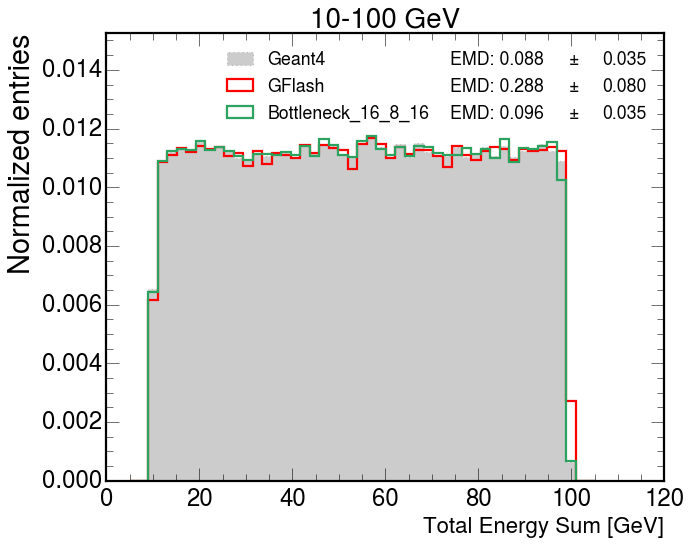

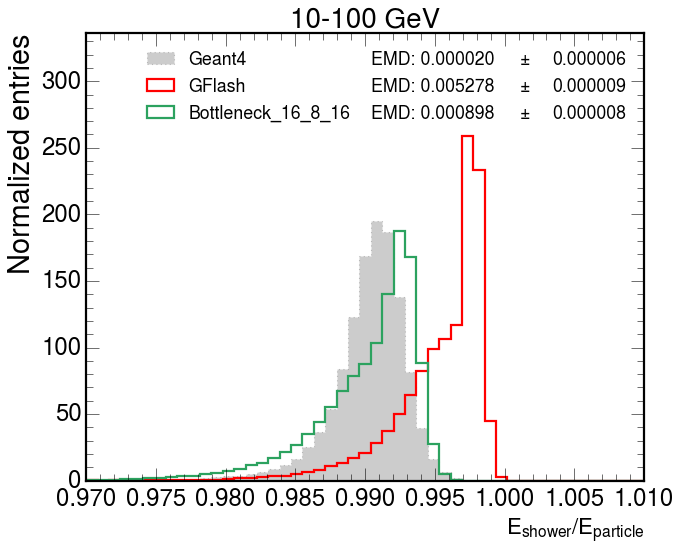

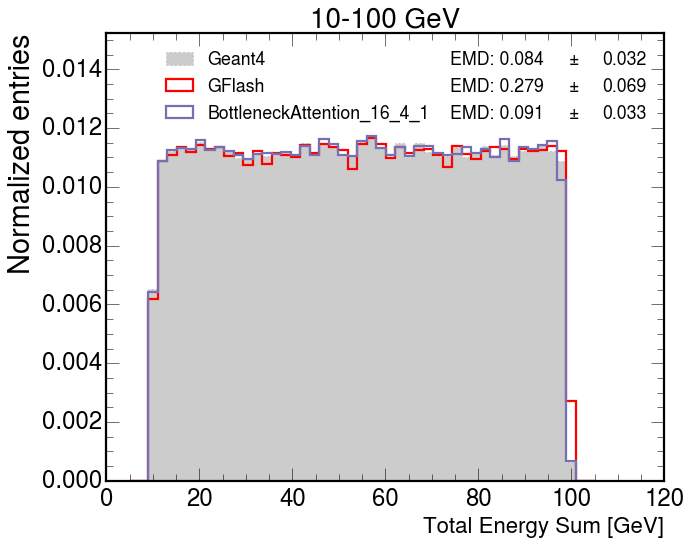

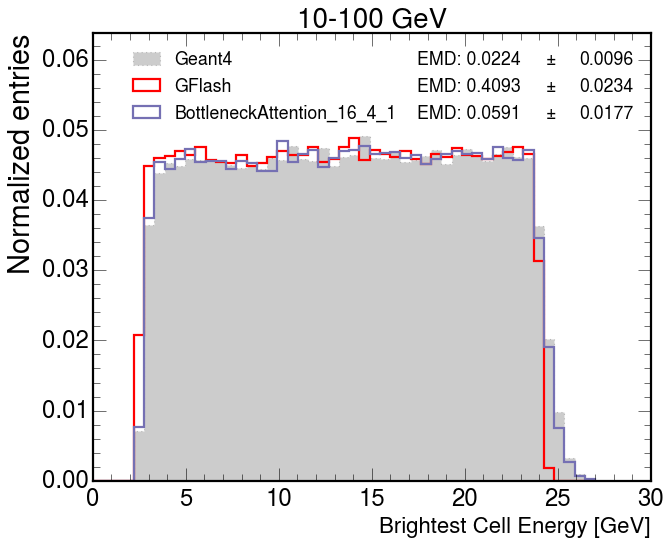

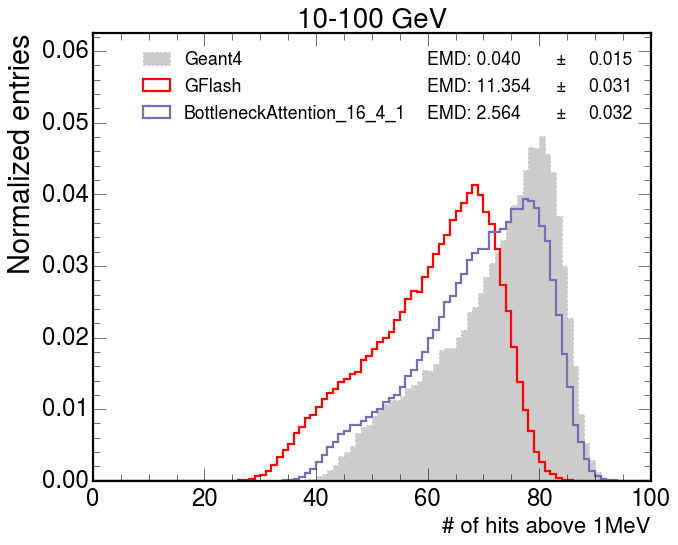

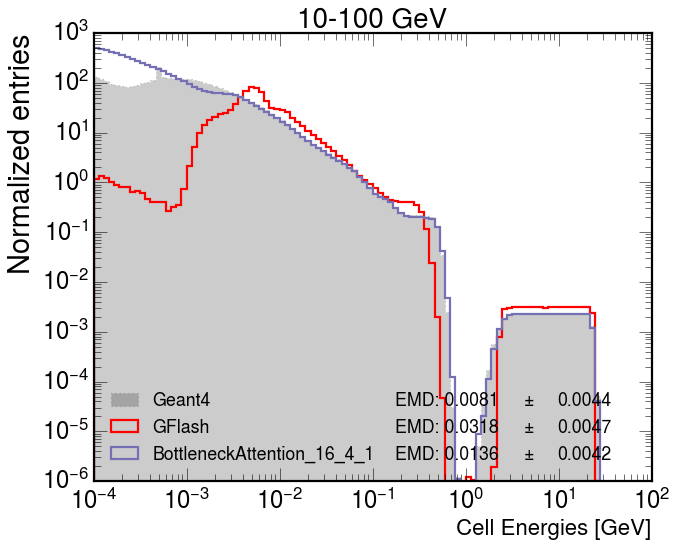

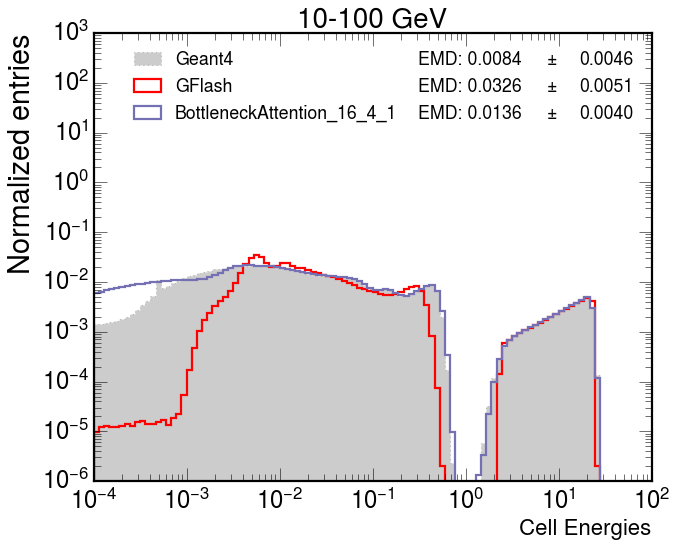

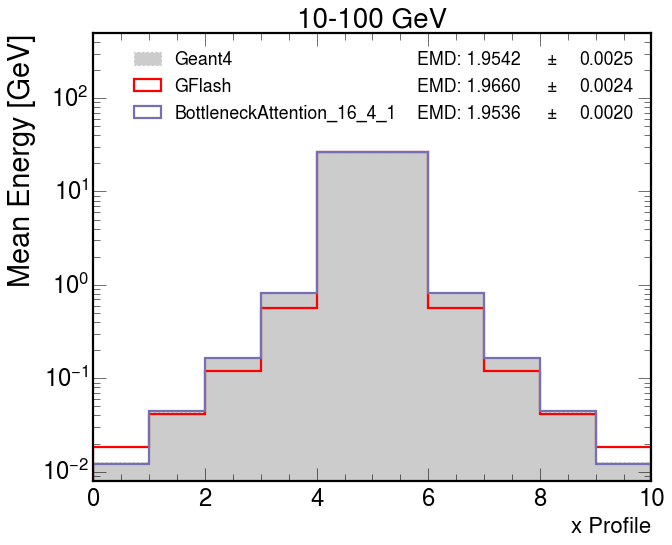

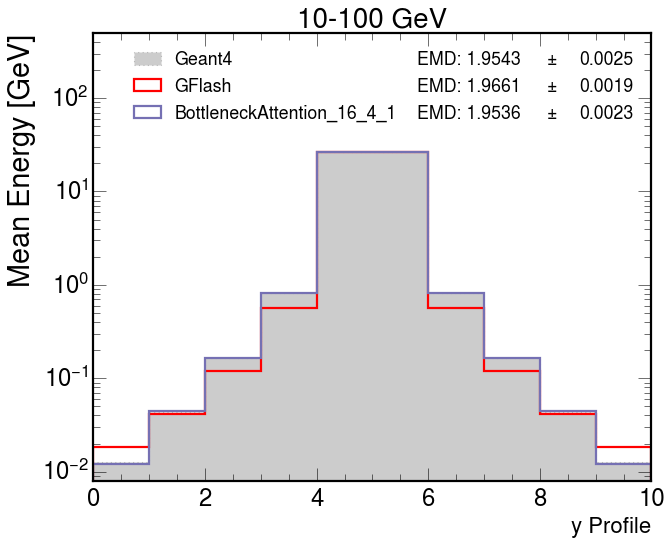

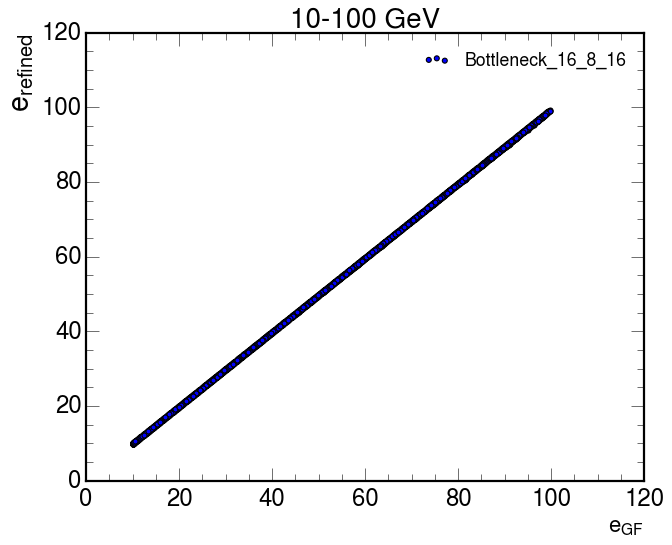

In [10]:
# energy_voxel_gflash_orig, energy_voxel_gflash_trafo, energy_gflash_trafo, energy_particle = sample(forward_or_backward = 'f', forward_or_backward_rev = 'b')

cutOff = 0.0

data_trafo = energy_voxel_gflash_trafo[:,-1]#*100

data_orig = energy_voxel_gflash_orig
data_full = np.load(file_path_g4 + '.npy')

data_full[data_full<0] = 0.0
data_orig[data_orig<0] = 0.0
data_trafo[data_trafo<0] = 0.0

weight_dict = {
    'Geant4': np.ones(data_full.shape[0]),
    'GFlash': np.ones(data_full.shape[0]),
    full_modelConv_name: np.ones(data_full.shape[0]),
    full_modelEnergy_name: np.ones(data_full.shape[0]),
}
triangle=True

y_lim_ratio_l = {'esum': [0.9, 1.1],
                 'esumfrac': [0.0, 2.0],
                 'emax': [0.0, 2.0],
                 'nhit': [0.0, 2.0],
                 'espec': [0.0, 2.0],
                 'ex': [0.0, 2.0],
                }
    
binning_l = {'esum': np.linspace(5,105,50),
             'esumfrac': np.linspace(0.97,1.01,50),
             'emax': np.linspace(0, 27,50),
             'nhit': np.linspace(0, 100,101),
             'espec': np.logspace(-4, 1.5, 100),
             'ex': np.linspace(0, 10,11),
            }

y_range_l = {'esum': None,
             'esumfrac': None,
             'emax': None,
             'nhit': None,
             'espec': [1e-6, 1e3],
             'ex': [8e-3, 5e2],
            }



print(data_full.shape)

### Esum 1D ###
feed_dict = {
    'Geant4': np.sum(data_full[:,:100],(1)),
    'GFlash': np.sum(data_orig,(1,2,3)),
    full_modelEnergy_name: energy_gflash_trafo[:,1],
}

fig,ax0 = histogram(feed_dict,weights = weight_dict,
                            label_loc= 'best',
                            xlabel='Total Energy Sum [GeV]', ylabel= 'Normalized entries',
                            binning = binning_l['esum'],triangle=triangle,
                            logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['esum'],
                            title='10-100 GeV', y_range= y_range_l['esum'])
fig.savefig(plots_dir_path + 'esum_1D.pdf')



### Esum 1D ###
feed_dict = {
    'Geant4': np.sum(data_full[:,:100],(1))/(data_full[:,200]/1000.0),
    'GFlash': np.sum(data_orig,(1,2,3))/energy_particle[:,0],
    full_modelEnergy_name: energy_gflash_trafo[:,1]/energy_particle[:,0],
}

fig,ax0 = histogram(feed_dict,weights = weight_dict,
                            label_loc= 'best',
                            xlabel='$E_{shower}/E_{particle}$', ylabel= 'Normalized entries',
                            binning = binning_l['esumfrac'],triangle=triangle,
                            logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['esumfrac'],
                            title='10-100 GeV', y_range= y_range_l['esumfrac'])
fig.savefig(plots_dir_path + 'esumfrac_1D.pdf')



### Esum ###
feed_dict = {
    'Geant4': np.sum(data_full[:,:100],(1)),
    'GFlash': np.sum(data_orig,(1,2,3)),
    full_modelConv_name: np.sum(data_trafo,(1,2,3)),
}

fig,ax0 = histogram(feed_dict,weights = weight_dict,
                            label_loc= 'best',
                            xlabel='Total Energy Sum [GeV]', ylabel= 'Normalized entries',
                            binning = binning_l['esum'],triangle=triangle,
                            logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['esum'],
                            title='10-100 GeV', y_range= y_range_l['esum'])
#ax0.set_xscale("log")
fig.savefig(plots_dir_path + 'esum.pdf')


### emax ###
feed_dict = {
    'Geant4': np.max(data_full[:,:100],(1)),
    'GFlash': np.max(data_orig,(1,2,3)),
    full_modelConv_name: np.max(data_trafo,(1,2,3)),
}

fig,ax0 = histogram(feed_dict,weights = weight_dict,
                            label_loc= 'best',
                            xlabel='Brightest Cell Energy [GeV]', ylabel= 'Normalized entries',
                            binning = binning_l['emax'],triangle=triangle,
                            logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['emax'],
                            title='10-100 GeV', y_range= y_range_l['emax'])
#ax0.set_xscale("log")
fig.savefig(plots_dir_path + 'emax.pdf')


# ### nhit ###
# def get_nhit(x):
#     temp = np.array(x)
#     temp = np.array(x)
#     temp[temp>1e-3] = 1
#     temp[temp<=1e-3] = 0
#     return temp


feed_dict = {
    'Geant4': np.sum(get_nhit(data_full[:,:100]),(1)),
    'GFlash': np.sum(get_nhit(data_orig),(1,2,3)),
    full_modelConv_name: np.sum(get_nhit(data_trafo),(1,2,3)),
}

fig,ax0 = histogram(feed_dict,weights = weight_dict,
                            label_loc= 'best',
                            xlabel='# of hits above 1MeV', ylabel= 'Normalized entries',
                            binning = binning_l['nhit'],triangle=triangle,
                            logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['nhit'],
                            title='10-100 GeV', y_range= y_range_l['nhit'])
#ax0.set_xscale("log")
fig.savefig(plots_dir_path + 'nhit.pdf')


### espec ###
feed_dict = {
    'Geant4': np.reshape(data_full[:,:100], -1),
    'GFlash': np.reshape(data_orig, -1),
    full_modelConv_name: np.reshape(data_trafo, -1),
}

weight_dict = {
    'Geant4': np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
    'GFlash': np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
    full_modelConv_name: np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
}

fig,ax0 = histogram(feed_dict,weights = weight_dict,
                            label_loc= 'best',
                            xlabel='Cell Energies [GeV]', ylabel= 'Normalized entries',
                            binning = binning_l['espec'], 
                            logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['espec'],
                            title='10-100 GeV', triangle=triangle, y_range= y_range_l['espec'])
ax0.set_xscale("log")
fig.savefig(plots_dir_path + 'espec.pdf')


### espec_norm ###
feed_dict = {
    'Geant4': np.reshape(data_full[:,:100], -1),
    'GFlash': np.reshape(data_orig, -1),
    full_modelConv_name: np.reshape(data_trafo, -1),
}

weight_dict = {
    'Geant4': np.ones(np.reshape(data_full[:,:100], -1).shape[0])/np.reshape(data_full[:,:100], -1).shape[0],
    'GFlash': np.ones(np.reshape(data_full[:,:100], -1).shape[0])/np.reshape(data_full[:,:100], -1).shape[0],
    full_modelConv_name: np.ones(np.reshape(data_full[:,:100], -1).shape[0])/np.reshape(data_full[:,:100], -1).shape[0],
}


fig,ax0 = histogram(feed_dict,weights = weight_dict,
                            label_loc= 'best', density=False,
                            xlabel='Cell Energies', ylabel= 'Normalized entries',
                            binning = binning_l['espec'], 
                            logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['espec'],
                            title='10-100 GeV', triangle=triangle, y_range= y_range_l['espec'])
ax0.set_xscale("log")
fig.savefig(plots_dir_path + 'espec_norm.pdf')

### ex ###
weight_dict = {
    'Geant4': np.reshape(np.sum(np.reshape(data_full[:,:100], (-1, 10, 10)), 2), -1)/data_full.shape[0],
    'GFlash': np.reshape(np.sum(np.reshape(data_orig, (-1, 10, 10)), 2), -1)/data_full.shape[0],
    full_modelConv_name: np.reshape(np.sum(np.reshape(data_trafo, (-1, 10, 10)), 2), -1)/data_full.shape[0],
}

feed_dict = {
    'Geant4': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
    'GFlash': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
    full_modelConv_name: np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
}

print(feed_dict['Geant4'].shape)


fig,ax0 = histogram(feed_dict,weights = weight_dict,
                            label_loc= 'best', density=False,
                            xlabel='x Profile', ylabel= 'Mean Energy [GeV]',
                            binning = binning_l['ex'],triangle=triangle,
                            logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['ex'],
                            title='10-100 GeV', y_range= y_range_l['ex'])
#ax0.set_xscale("log")
fig.savefig(plots_dir_path + 'ex.pdf')

### ey ###
weight_dict = {
    'Geant4': np.reshape(np.sum(np.reshape(data_full[:,:100], (-1, 10, 10)), 1), -1)/data_full.shape[0],
    'GFlash': np.reshape(np.sum(np.reshape(data_orig, (-1, 10, 10)), 1), -1)/data_full.shape[0],
    full_modelConv_name: np.reshape(np.sum(np.reshape(data_trafo, (-1, 10, 10)), 1), -1)/data_full.shape[0],
}

feed_dict = {
    'Geant4': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
    'GFlash': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
    full_modelConv_name: np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
}

print(feed_dict['Geant4'].shape)


fig,ax0 = histogram(feed_dict,weights = weight_dict,
                            label_loc= 'best', density=False,
                            xlabel='y Profile', ylabel= 'Mean Energy [GeV]',
                            binning = binning_l['ex'],triangle=triangle,
                            logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['ex'],
                            title='10-100 GeV', y_range= y_range_l['ex'])
#ax0.set_xscale("log")
fig.savefig(plots_dir_path + 'ey.pdf')




fig,ax0 = scatter(xdata=energy_gflash_trafo[:10000,0], ydata=energy_gflash_trafo[:10000,1], 
                         data_label = full_modelEnergy_name,
                         xlabel='$e_{GF}$',ylabel='$e_{refined}$',
                         label_loc='best', title='10-100 GeV')
fig.savefig(plots_dir_path + 'scatter.pdf')


In [11]:
shower_dict = {}
for energy in [20, 50, 80]:

    file_path_gflash = data_dir_path + 'run_GFlash01_100k_{:d}GeV_full.npy'.format(energy)
    file_path_g4 = data_dir_path + 'run_Geant_100k_{:d}GeV_full.npy'.format(energy)

    data = load_data(file_path_gflash, file_path_g4, normalize_energy=True, shuffle=False, plotting=True)

    # energy_voxel_g4 = np.load(file_path_g4)[:, 0:100].astype(np.float32)
    # energy_voxel_gflash  = np.load(file_path_gflash)[:, 0:100].astype(np.float32)

    # energy_particle_g4 = np.load(file_path_g4)[:, 200:201].astype(np.float32)/10000.0
    # energy_particle_gflash  = np.load(file_path_gflash)[:, 200:201].astype(np.float32)/10000.0

    # if energy_particle_gflash.shape[1] == 0:
    #     energy_particle_g4 = np.ones((energy_voxel_g4.shape[0], 1)).astype(np.float32)/10000.0*50000.0
    #     energy_particle_gflash  = np.ones((energy_particle_gflash.shape[0], 1)).astype(np.float32)/10000.0*50000.0


    # energy_g4 = np.sum(energy_voxel_g4, 1, keepdims=True)
    # energy_gflash = np.sum(energy_voxel_gflash, 1, keepdims=True)

    # energy_voxel_g4 = np.reshape(energy_voxel_g4, (-1, 1, 10, 10))
    # energy_voxel_gflash = np.reshape(energy_voxel_gflash, (-1, 1, 10, 10))

    # energy_voxel_g4 = energy_voxel_g4/np.tile(np.reshape(energy_g4, (-1, 1, 1, 1)), (1, 1, 10, 10))
    # energy_voxel_gflash = energy_voxel_gflash/np.tile(np.reshape(energy_gflash, (-1, 1, 1, 1)), (1, 1, 10, 10))

    # energy_g4 = energy_g4/energy_particle_g4
    # energy_gflash = energy_gflash/energy_particle_gflash

    # energy_voxel_g4 = (energy_voxel_g4 - shifter_g4)/scaler_g4
    # energy_voxel_gflash = (energy_voxel_gflash - shifter_gflash)/scaler_gflash

    # energy_g4 = (energy_g4 - shifter_energy_g4)/scaler_energy_g4
    # energy_gflash = (energy_gflash - shifter_energy_gflash)/scaler_energy_gflash

    batch_size = 25000

    npar = int(energy_voxel_g4.shape[0])

    X_init = energy_voxel_gflash
    Y_init = np.concatenate((energy_gflash, energy_g4, energy_particle_gflash), 1)
    init_sample = torch.tensor(X_init).view(X_init.shape[0], 1, 10, 10)
    init_lable = torch.tensor(Y_init)
    scaling_factor = 7
    #init_sample = (init_sample - init_sample.mean()) / init_sample.std() * scaling_factor
    init_ds = TensorDataset(init_sample, init_lable)
    init_dl = DataLoader(init_ds, batch_size=batch_size, shuffle=False)
    #init_dl = repeater(init_dl)
    print(init_sample.shape)

    X_final = energy_voxel_g4
    Y_final = np.concatenate((energy_g4, energy_gflash, energy_particle_g4), 1)
    scaling_factor = 7.
    final_sample = torch.tensor(X_final).view(X_final.shape[0], 1, 10, 10)
    final_label = torch.tensor(Y_final)
    #final_sample = (final_sample - final_sample.mean()) / final_sample.std() * scaling_factor
    final_ds = TensorDataset(final_sample, final_label)
    final_dl = DataLoader(final_ds, batch_size=batch_size, shuffle=False)
    #final_dl = repeater(final_dl)

    dls = {'f': init_dl, 'b': final_dl}

    #energy_voxel_gflash_orig, energy_voxel_gflash_trafo, energy_gflash_trafo, _ = sample(forward_or_backward = 'f', forward_or_backward_rev = 'b')
    # energy_voxel_gflash_orig, energy_voxel_gflash_trafo, energy_gflash_trafo, energy_particle = sample(forward_or_backward = 'f', forward_or_backward_rev = 'b')
    sample = sample_data(dls, data, netsEnergy, netsConv, de, d,
                     num_steps_voxel, num_steps_energy,
                     gammas_voxel, gammas_energy, device,
                     forward_or_backward = 'f', forward_or_backward_rev = 'b')

    energy_voxel_gflash_orig = sample['energy_voxel_gflash_orig']
    energy_voxel_gflash_trafo = sample['energy_voxel_gflash_trafo']
    energy_gflash_trafo = sample['energy_gflash_trafo']
    energy_particle = sample['energy_particle']
    
    data_trafo = energy_voxel_gflash_trafo[:,-1]#*100

    data_orig = energy_voxel_gflash_orig
    data_full = np.load(file_path_g4)

    data_full[data_full<0] = 0.0
    data_orig[data_orig<0] = 0.0
    data_trafo[data_trafo<0] = 0.0
    
    shower_dict[energy] = [data_full, data_orig, data_trafo, energy_gflash_trafo]
    

torch.Size([100000, 1, 10, 10])
torch.Size([100000, 1, 10, 10])
torch.Size([100000, 1, 10, 10])


(100000, 201)
Geant4
EMD distance is: 0.00030234018633080594+-8.159344248303074e-05
GFlash
EMD distance is: 0.11839089715535403+-0.00016349577055483106
Bottleneck_16_8_16
EMD distance is: 0.02192258670048303+-9.90573109820228e-05
Total Energy Sum [GeV], 20 GeV , Bottleneck_16_8_16:   & 0.00030$\pm$0.00008 & 0.11839$\pm$0.00016 & 0.02192$\pm$0.00010
Total Energy Sum [GeV], 20 GeV , Bottleneck_16_8_16:   & 0.00030(8) & 0.1184(2) & 0.0219(1)
Geant4
EMD distance is: 0.00032586622282662446+-8.956640289913088e-05
GFlash
EMD distance is: 0.11839278514134646+-0.00014849383097815494
BottleneckAttention_16_4_1
EMD distance is: 0.02280447670624151+-0.00018097551692771796
Total Energy Sum [GeV], 20 GeV , BottleneckAttention_16_4_1:   & 0.00033$\pm$0.00009 & 0.11839$\pm$0.00015 & 0.02280$\pm$0.00018
Total Energy Sum [GeV], 20 GeV , BottleneckAttention_16_4_1:   & 0.00033(9) & 0.1184(1) & 0.0228(2)
Geant4
EMD distance is: 0.0012876406449999728+-0.0003997792102169431
GFlash
EMD distance is: 0.3379384

/tmp/ipykernel_1583384/3353862720.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(9, 7))


Geant4
EMD distance is: 0.00831357382464188+-0.005759147856028249
GFlash
EMD distance is: 0.0504298122975651+-0.005292249254922513
BottleneckAttention_16_4_1
EMD distance is: 0.010765956287369314+-0.006370481481698274
Cell Energies [GeV], 80 GeV , BottleneckAttention_16_4_1:   & 0.0083$\pm$0.0058 & 0.0504$\pm$0.0053 & 0.0108$\pm$0.0064
Cell Energies [GeV], 80 GeV , BottleneckAttention_16_4_1:   & 0.008(6) & 0.050(5) & 0.011(6)
Geant4
EMD distance is: 1.9543140522528823+-0.0022063971100741223
GFlash
EMD distance is: 1.965401536974664+-0.001969221616674789
BottleneckAttention_16_4_1
EMD distance is: 1.953335474809998+-0.0022492106988251832
x Profile, 80 GeV , BottleneckAttention_16_4_1:   & 1.9543$\pm$0.0022 & 1.9654$\pm$0.0020 & 1.9533$\pm$0.0022
x Profile, 80 GeV , BottleneckAttention_16_4_1:   & 1.954(2) & 1.965(2) & 1.953(2)
Geant4
EMD distance is: 1.9535477748181043+-0.0017852268801324463
GFlash
EMD distance is: 1.965386856841846+-0.00173408764914604
BottleneckAttention_16_4_1
EMD d

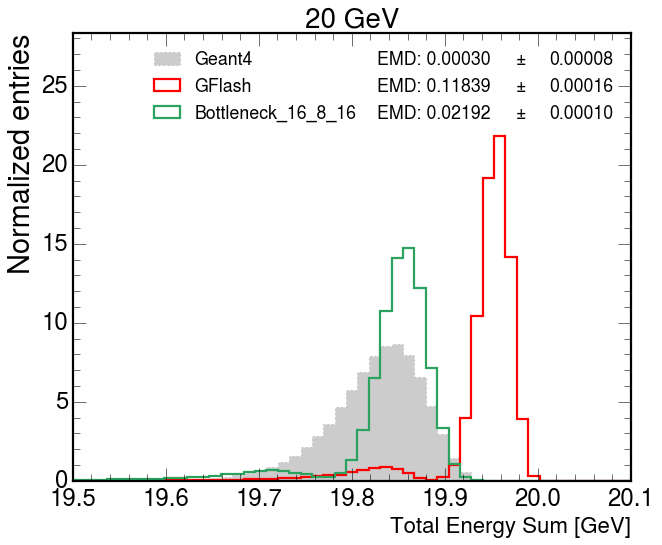

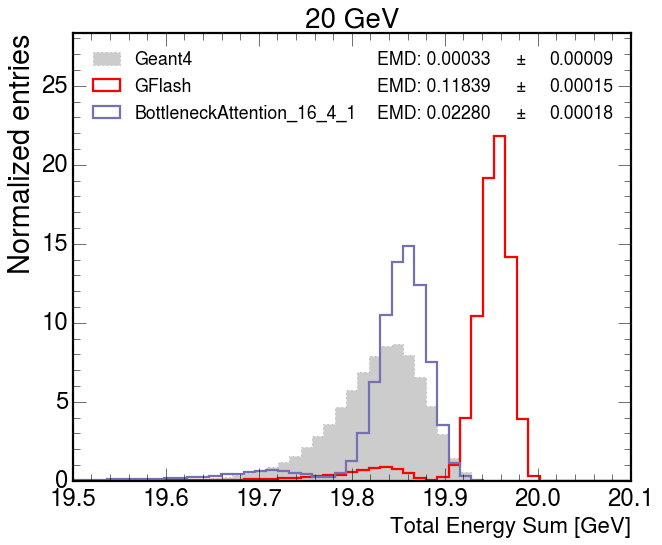

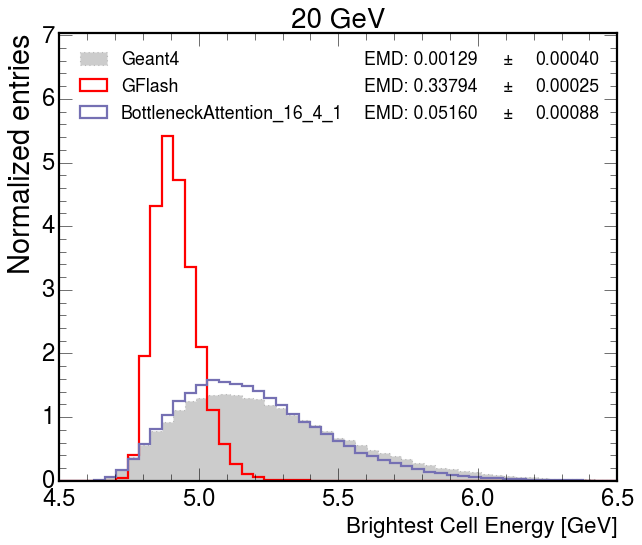

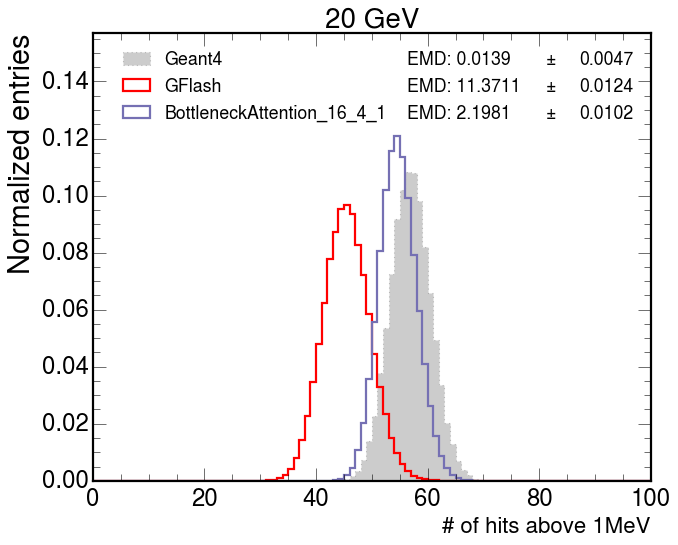

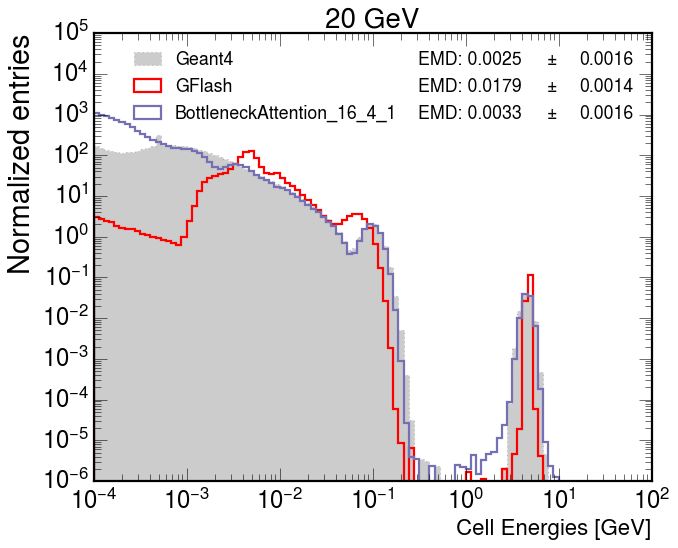

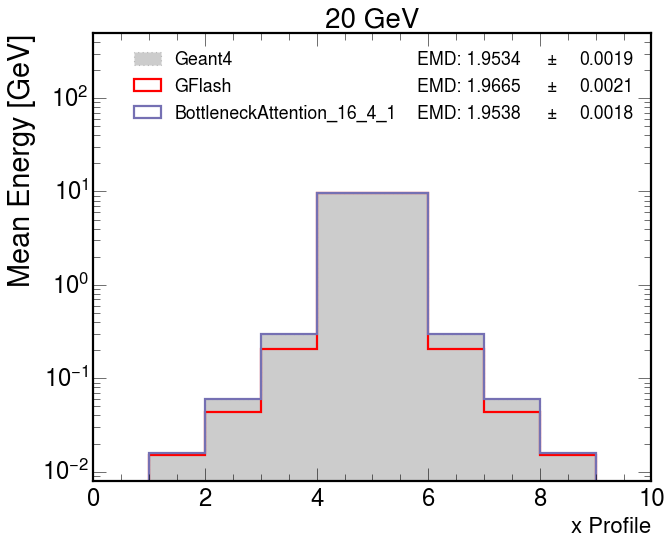

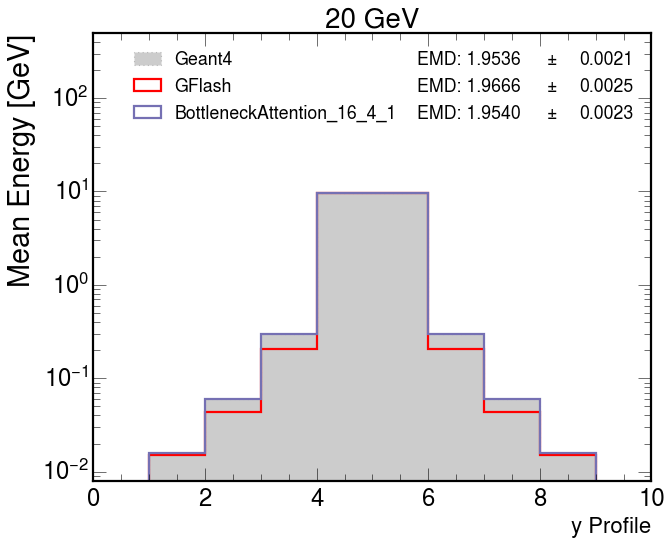

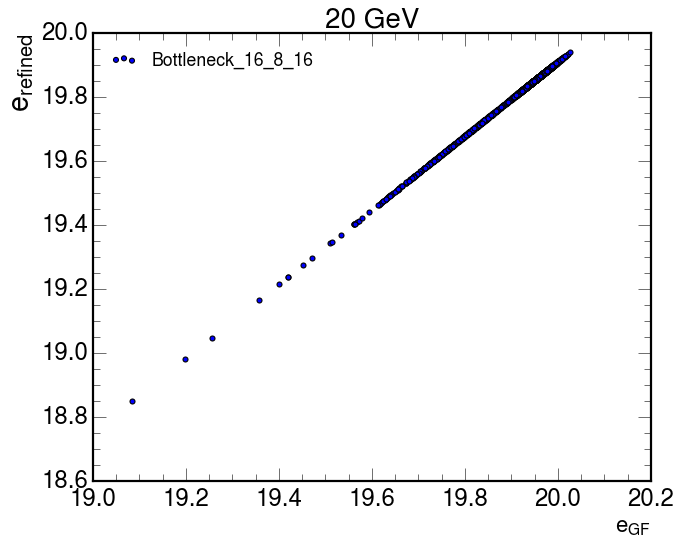

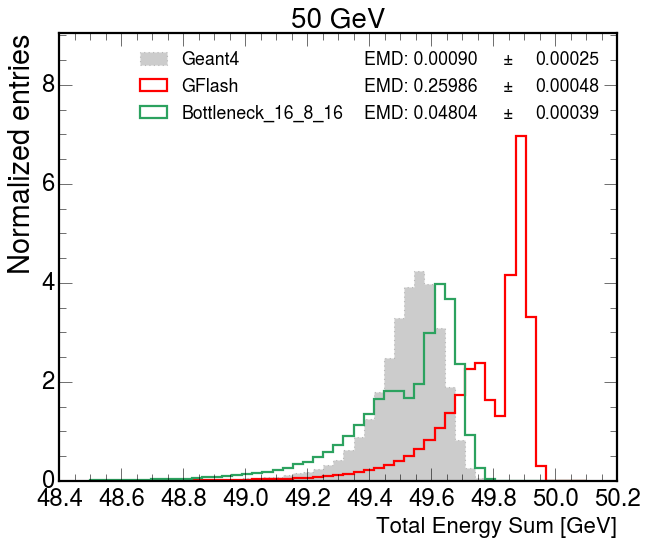

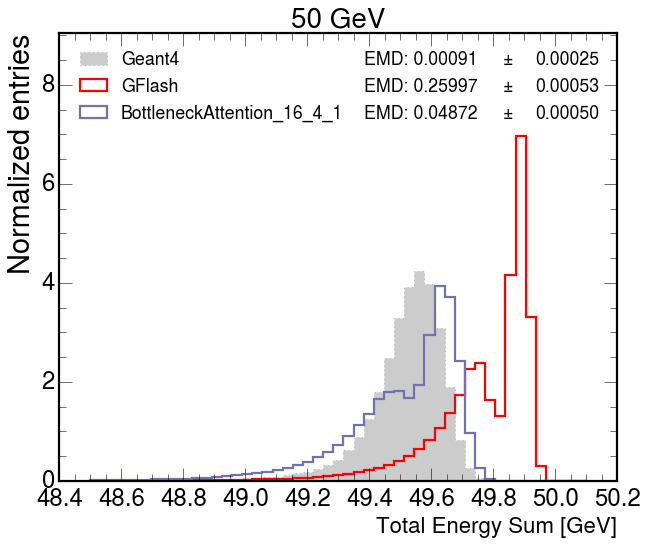

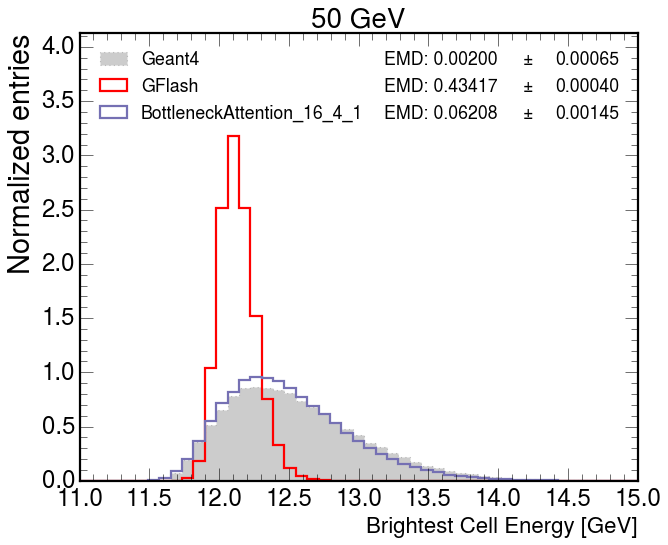

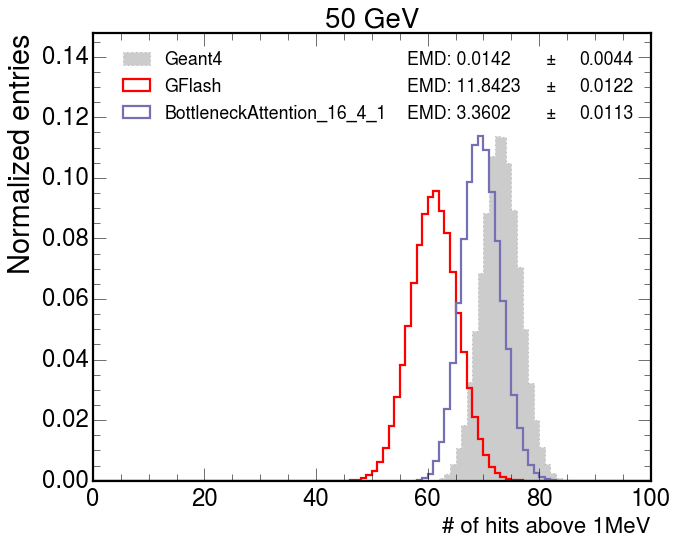

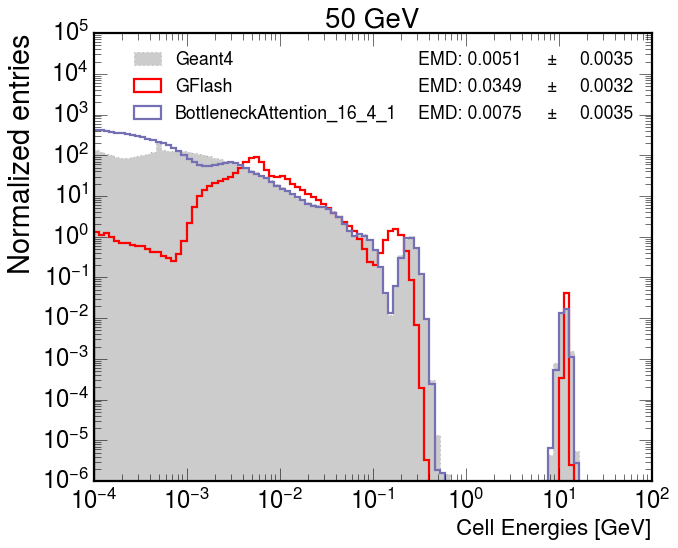

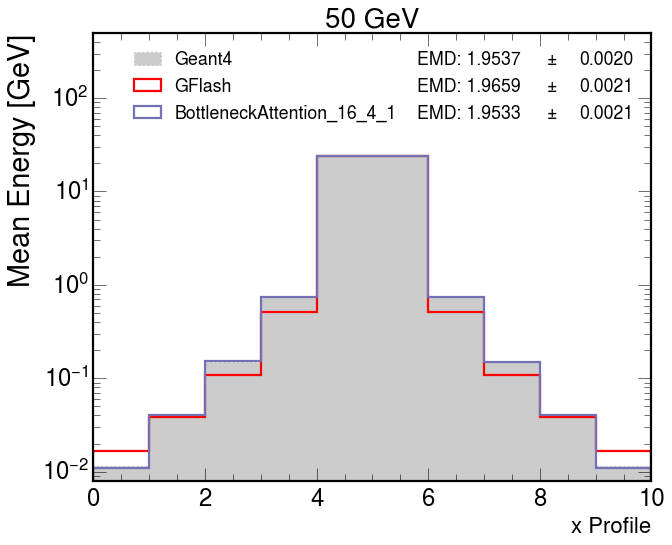

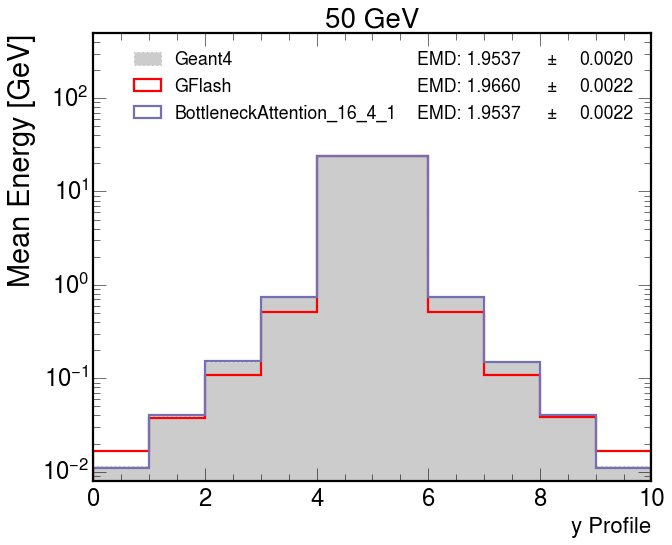

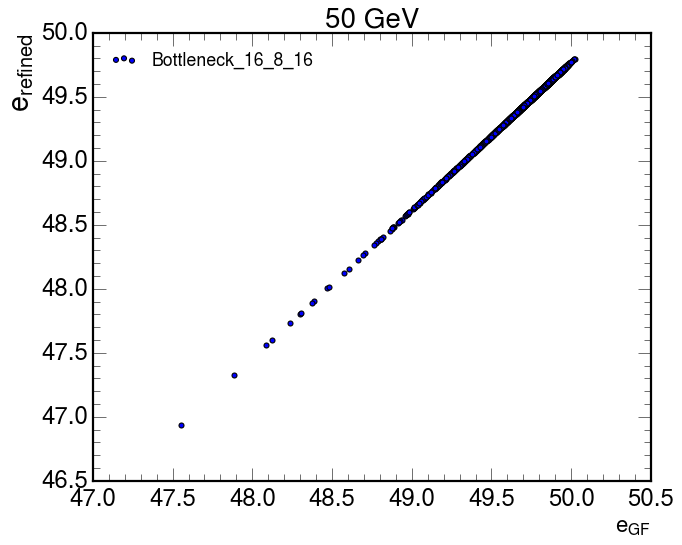

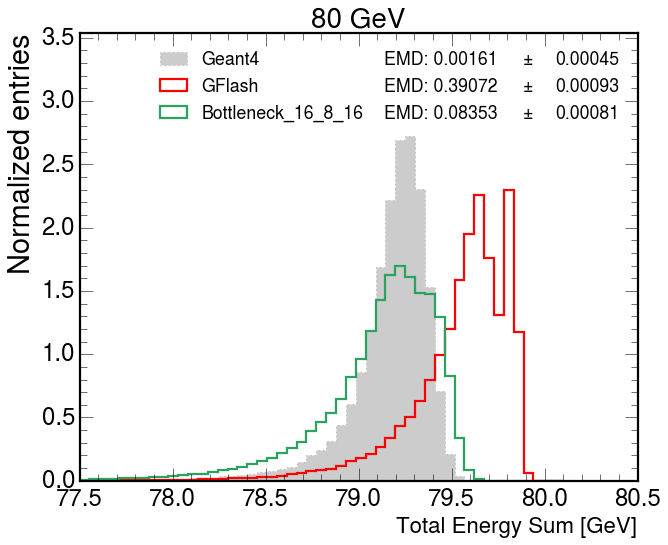

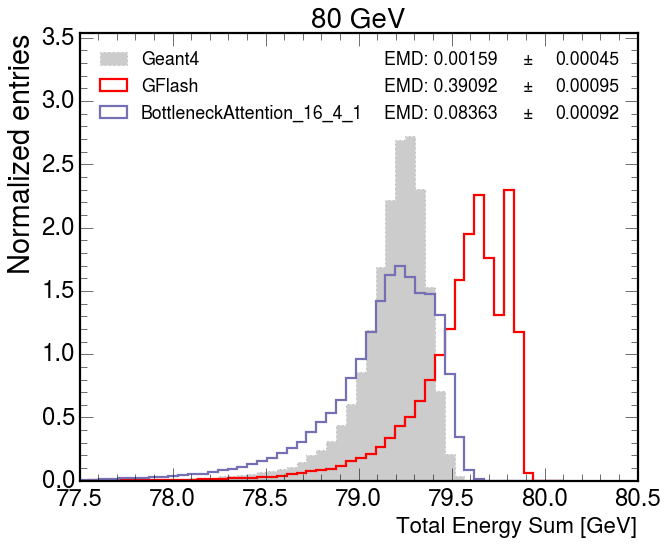

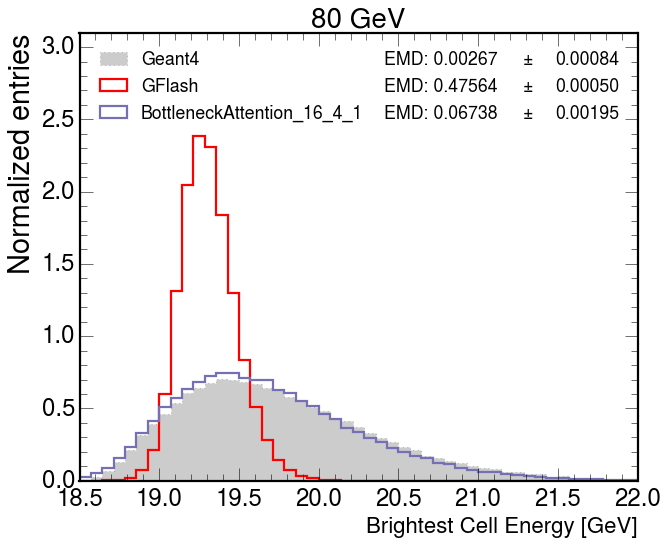

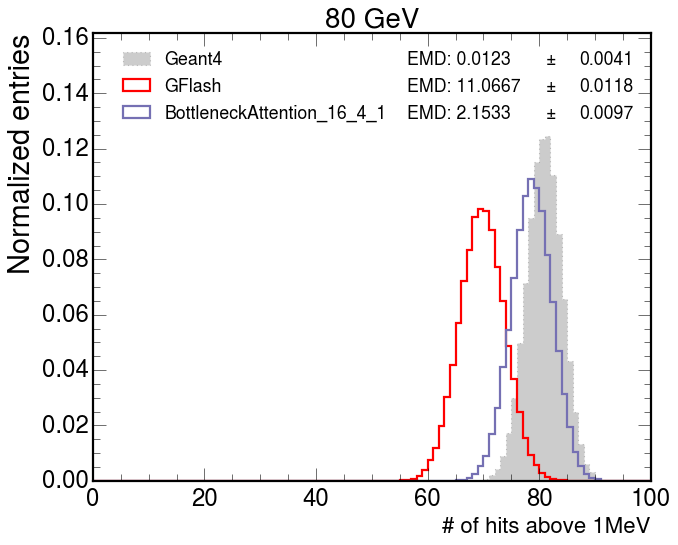

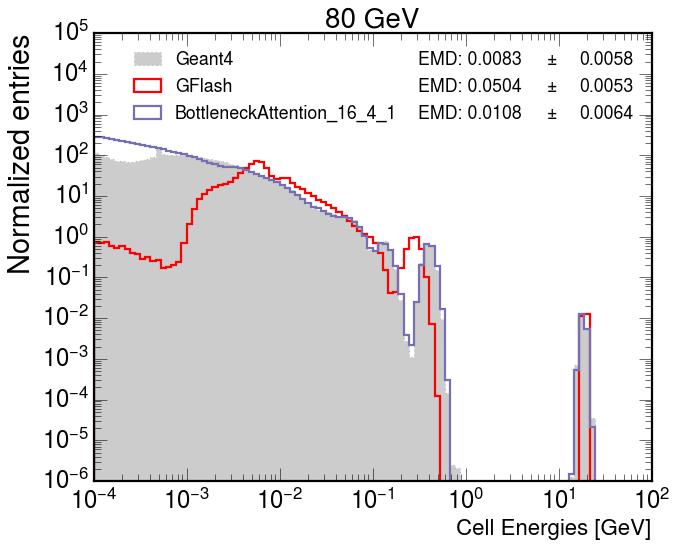

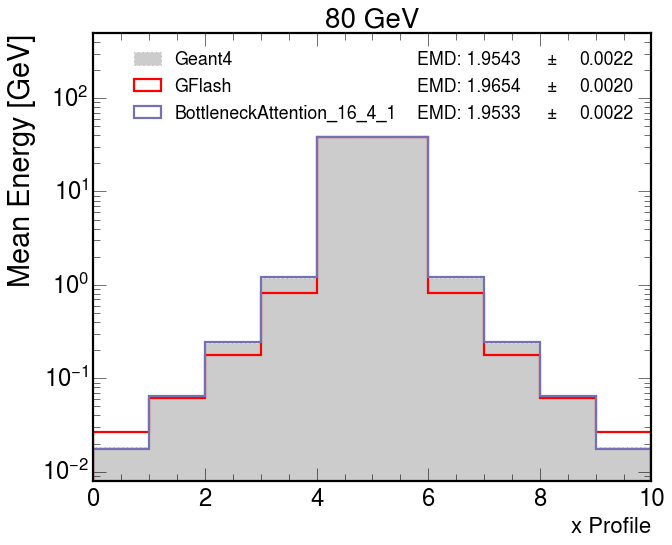

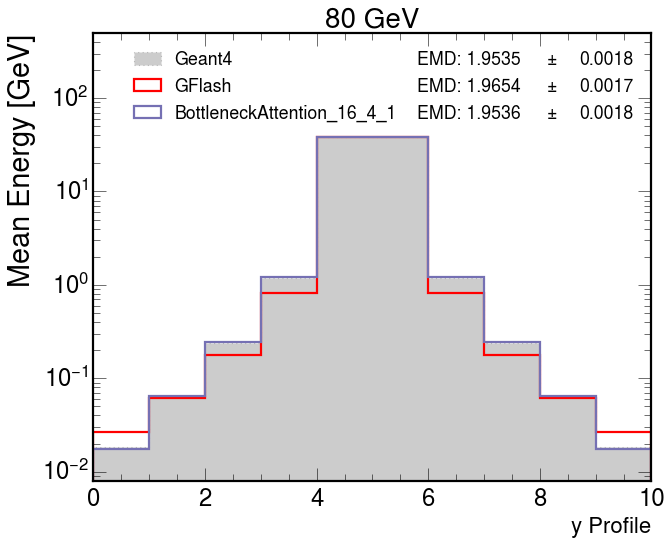

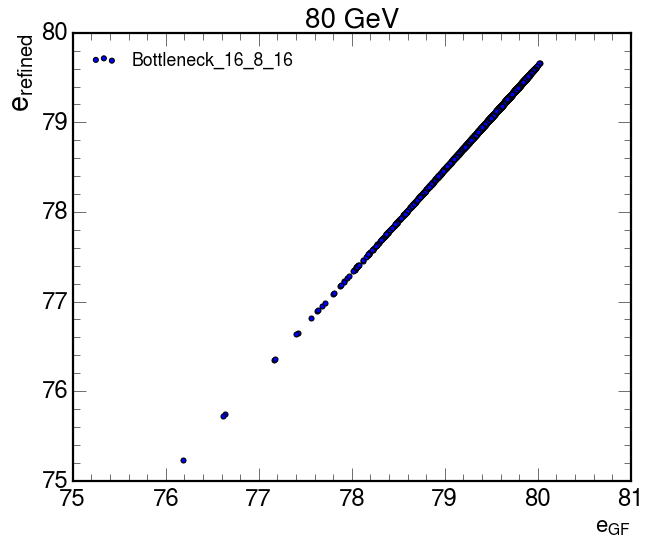

In [12]:
for energy in [20, 50, 80]:

    [data_full, data_orig, data_trafo, energy_gflash_trafo] = shower_dict[energy]

    
    weight_dict = {
        'Geant4': np.ones(data_full.shape[0]),
        'GFlash': np.ones(data_full.shape[0]),
        full_modelConv_name: np.ones(data_full.shape[0]),
        full_modelEnergy_name: np.ones(data_full.shape[0]),
    }
    triangle=True

    y_lim_ratio_l = {'esum': [0.0, 2.0],
                     'emax': [0.0, 2.0],
                     'nhit': [0.0, 2.0],
                     'espec': [0.0, 2.0],
                     'ex': [0.0, 2.0],
                    }
    
    y_range_l = {'esum_20': None,
                 'esum_50': None,
                 'esum_80': None,
                 'emax_20': None,
                 'emax_50': None,
                 'emax_80': None,
                 'nhit_20': None,
                 'nhit_50': None,
                 'nhit_80': None,
                 'espec': [1e-6, 1e5],
                 'ex': [8e-3, 5e2],
            }



    binning_l = {'esum_20': np.linspace(19.5,20.1,50),
                 'esum_50': np.linspace(48.5,50.1,50),
                 'esum_80': np.linspace(77.5,80.1,50),
                 'emax_20': np.linspace(4.5, 6.5,50),
                 'emax_50': np.linspace(11,15,50),
                 'emax_80': np.linspace(18.5,22,50),
                 'nhit_20': np.linspace(0, 100,101),
                 'nhit_50': np.linspace(0, 100,101),
                 'nhit_80': np.linspace(0, 100,101),
                 'espec': np.logspace(-4, 1.5, 100),
                 'ex': np.linspace(0, 10,11),
                }

    print(data_full.shape)

    ### Esum 1d ###
    feed_dict = {
        'Geant4': np.sum(data_full[:,:100],(1)),
        'GFlash': np.sum(data_orig,(1,2,3)),
        full_modelEnergy_name: energy_gflash_trafo[:,1],
    }

    fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                label_loc= 'best',
                                xlabel='Total Energy Sum [GeV]', ylabel= 'Normalized entries',
                                binning = binning_l['esum_{:d}'.format(energy)] ,triangle=triangle,
                                logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['esum'],
                                title='{:d} GeV'.format(energy), y_range= y_range_l['esum_{:d}'.format(energy)])
    #ax0.set_xscale("log")
    fig.savefig(plots_dir_path + 'esum_1D_{:d}GeV.pdf'.format(energy))

    #break
    
    ### Esum ###
    feed_dict = {
        'Geant4': np.sum(data_full[:,:100],(1)),
        'GFlash': np.sum(data_orig,(1,2,3)),
        full_modelConv_name: np.sum(data_trafo,(1,2,3)),
    }

    fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                label_loc= 'best',
                                xlabel='Total Energy Sum [GeV]', ylabel= 'Normalized entries',
                                binning = binning_l['esum_{:d}'.format(energy)] ,triangle=triangle,
                                logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['esum'],
                                title='{:d} GeV'.format(energy), y_range= y_range_l['esum_{:d}'.format(energy)])
    #ax0.set_xscale("log")
    fig.savefig(plots_dir_path + 'esum_{:d}GeV.pdf'.format(energy))


    ### emax ###
    feed_dict = {
        'Geant4': np.max(data_full[:,:100],(1)),
        'GFlash': np.max(data_orig,(1,2,3)),
        full_modelConv_name: np.max(data_trafo,(1,2,3)),
    }

    fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                label_loc= 'best',
                                xlabel='Brightest Cell Energy [GeV]', ylabel= 'Normalized entries',
                                binning = binning_l['emax_{:d}'.format(energy)],triangle=triangle,
                                logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['emax'],
                                title='{:d} GeV'.format(energy), y_range= y_range_l['emax_{:d}'.format(energy)])
    #ax0.set_xscale("log")
    fig.savefig(plots_dir_path + 'emax_{:d}GeV.pdf'.format(energy))


    feed_dict = {
        'Geant4': np.sum(get_nhit(data_full[:,:100]),(1)),
        'GFlash': np.sum(get_nhit(data_orig),(1,2,3)),
        full_modelConv_name: np.sum(get_nhit(data_trafo),(1,2,3)),
    }

    fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                label_loc= 'best',
                                xlabel='# of hits above 1MeV', ylabel= 'Normalized entries',
                                binning = binning_l['nhit_{:d}'.format(energy)],triangle=triangle,
                                logy=False, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['nhit'],
                                title='{:d} GeV'.format(energy), y_range= y_range_l['nhit_{:d}'.format(energy)])
    #ax0.set_xscale("log")
    fig.savefig(plots_dir_path + 'nhit_{:d}GeV.pdf'.format(energy))
    
    
    feed_dict = {
        'Geant4': get_espec(np.reshape(data_full[:,:100], -1)),
        'GFlash': get_espec(np.reshape(data_orig, -1)),
        full_modelConv_name: get_espec(np.reshape(data_trafo, -1)),
    }

    weight_dict = {
        'Geant4': np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
        'GFlash': np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
        full_modelConv_name: np.ones(np.reshape(data_full[:,:100], -1).shape[0]),
    }

    fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                label_loc= 'best',
                                xlabel='Cell Energies [GeV]', ylabel= 'Normalized entries',
                                binning = binning_l['espec'], 
                                logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['espec'],
                                title='{:d} GeV'.format(energy), triangle=triangle, y_range= y_range_l['espec'])
    ax0.set_xscale("log")
    fig.savefig(plots_dir_path + 'espec_{:d}GeV.pdf'.format(energy))

    ### ex ###
    weight_dict = {
        'Geant4': np.reshape(np.sum(np.reshape(data_full[:,:100], (-1, 10, 10)), 2), -1)/data_full.shape[0],
        'GFlash': np.reshape(np.sum(np.reshape(data_orig, (-1, 10, 10)), 2), -1)/data_full.shape[0],
        full_modelConv_name: np.reshape(np.sum(np.reshape(data_trafo, (-1, 10, 10)), 2), -1)/data_full.shape[0],
    }

    feed_dict = {
        'Geant4': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
        'GFlash': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
        full_modelConv_name: np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
    }
    
    
    fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                label_loc= 'best', density=False,
                                xlabel='x Profile', ylabel= 'Mean Energy [GeV]',
                                binning = binning_l['ex'],triangle=triangle,
                                logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['ex'],
                                title='{:d} GeV'.format(energy), y_range= y_range_l['ex'])
    #ax0.set_xscale("log")
    fig.savefig(plots_dir_path + 'ex_{:d}GeV.pdf'.format(energy))

    ### ey ###
    weight_dict = {
        'Geant4': np.reshape(np.sum(np.reshape(data_full[:,:100], (-1, 10, 10)), 1), -1)/data_full.shape[0],
        'GFlash': np.reshape(np.sum(np.reshape(data_orig, (-1, 10, 10)), 1), -1)/data_full.shape[0],
        full_modelConv_name: np.reshape(np.sum(np.reshape(data_trafo, (-1, 10, 10)), 1), -1)/data_full.shape[0],
    }

    feed_dict = {
        'Geant4': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
        'GFlash': np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
        full_modelConv_name: np.tile(np.arange(0.5, 9.6, 1), data_full.shape[0]),
    }


    fig,ax0 = histogram(feed_dict,weights = weight_dict,
                                label_loc= 'best', density=False,
                                xlabel='y Profile', ylabel= 'Mean Energy [GeV]',
                                binning = binning_l['ex'],triangle=triangle,
                                logy=True, reference_name='Geant4', y_lim_ratio = y_lim_ratio_l['ex'],
                                title='{:d} GeV'.format(energy), y_range= y_range_l['ex'])
    #ax0.set_xscale("log")
    fig.savefig(plots_dir_path + 'ey_{:d}GeV.pdf'.format(energy))


    fig,ax0 = scatter(xdata=energy_gflash_trafo[:10000,0], ydata=energy_gflash_trafo[:10000,1], 
                             data_label = full_modelEnergy_name,
                             xlabel='$e_{GF}$',ylabel='$e_{refined}$',
                             label_loc='best',title='{:d} GeV'.format(energy))
    fig.savefig(plots_dir_path + 'scatter_{:d}GeV.pdf'.format(energy))